# Assignment

In [1]:
print("This Notebook is working")

This Notebook is working


In [2]:
# Import 
import matplotlib as plt

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [3]:
## INITIALISE THE ENVIRONMENT
env=Chess_Env(size_board)

In [4]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 3 0 0]
 [0 0 0 1]
 [0 0 2 0]]
check?  0
dofk2  3

[[0 3 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 1]]
0  0
check?  0
dofk2  2

[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 0 0 3]
 [0 0 0 0]
 [0 0 2 1]]
0  0
check?  0
dofk2  1

[[0 0 0 3]
 [0 0 0 0]
 [0 0 2 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  0

[[0 0 0 3]
 [0 0 0 0]
 [0 0 2 1]
 [0 0 0 0]]
0.0  1
check?  0
dofk2  0


## Helper functions to print current state

In [5]:
# exponential moving average
def ema(array, alpha=0.001):
    # initialize a numpy array
    exponential_average = np.full(len(array), np.nan)
    
    # set the first value of the ema
    exponential_average[0] = array[0]
    
    # for every data point (starting from the second one)
    for i in range(1, len(array)):
        
        # calculate the ema
        exponential_average[i] = alpha * array[i] + (1 - alpha) * exponential_average[i-1]
        
    # returns the ema and the time range
    return exponential_average, np.arange(len(array))

In [6]:
ema_prev = 0
def display_progress(episode, nr_actions, R, time_step=100, alpha=0.001):
    # reference global ema_prev
    global ema_prev
    
    # if a new process started initialize the previous ema
    if episode == 0:
        ema_prev = 0
    
    # calculate the ema
    ema = alpha*R + (1-alpha)*ema_prev
    
    # set previous to current
    ema_prev = ema
    
    # display progress bar only every 100th episode
    if not episode % time_step == 0:
        return
    
    print(f"==== In episode {episode}; Reward: {round(ema,4)}; Nr of needed moves: {nr_actions}")
    return ema_prev

In [7]:
nr2name={
    1: "Enemy King",
    2: "Agent Queen",
    3: "Agent King"
}

name2nr = {name: nr for nr, name in nr2name.items()}
    
# returns one-hot-encoded chessboard of a certain figure    
def get_position_of(name, X_features):
    nr = name2nr[name]
    print(f"Position of the {name} one-hot-encoded is:")
    return X_features[(nr-1)*16: nr*16]

def get_possible_movement_king(X_features):
    print(f"Positions to move to for enemy king are:")
    return X_features[48:56]

def get_king_threatened(X_features):
    print(f'The King is {"not" if X_features[57]==0 else ""} threatened')
    
def get_movement_agent(name, allowed_actions):
    nr = name2nr[name]
    if nr==2:
        print(f"Chessboard, where {name}{name} can move to (except the field she is on):")
        return allowed_actions[8:].flatten()
    else:
        print(f"Fields arround {name} where the {name} can move to:")
        return allowed_actions[0:8].flatten()

In [8]:
S,X,allowed_a=env.Initialise_game()   

# where S is the (initial) state of the chess board
print("S resembles the state of the chess board as a 2D array")
for piece in range(1,4):
    print(f"{piece} = {nr2name[piece]}")
print("")
print(S)

print("\n")

# where X are the features (input to neural network) of the chessboard
print('''X resembles the state of the game (positions of each piece, + possible fields enemy king can move + king threatened)''')
for piece in range(1,4):
    print(get_position_of(nr2name[piece], X))
    print("")
    
print(f"Input size of X {len(X)}")
print(get_possible_movement_king(X))
print("")
get_king_threatened(X)
print("")

# where allowed_a represents all actions that can be taken by the agent (moving queen or king)
for piece in range(2,4):
    print(get_movement_agent(nr2name[piece], allowed_a))
    print("")


S resembles the state of the chess board as a 2D array
1 = Enemy King
2 = Agent Queen
3 = Agent King

[[0 0 0 0]
 [0 1 0 0]
 [0 0 0 2]
 [0 3 0 0]]


X resembles the state of the game (positions of each piece, + possible fields enemy king can move + king threatened)
Position of the Enemy King one-hot-encoded is:
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Position of the Agent Queen one-hot-encoded is:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

Position of the Agent King one-hot-encoded is:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Input size of X 58
Positions to move to for enemy king are:
[1. 0. 0. 1. 0. 0. 0. 0.]

The King is not threatened

Chessboard, where Agent QueenAgent Queen can move to (except the field she is on):
[0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 1]

Fields arround Agent King where the Agent King can move to:
[1 0 0 1 1 0 0 0]



# Q-Learning Algorithm

In [9]:
# set the hyper parameters for training

# number of nodes in the hidden layer
size_hidden_layer = 200

# exploit our current knowledge with 1-epsilon and take a random action with probability epsilon (explore)
epsilon_0 = 0.2  

# how quick epsilon is decaying
beta_0 = 0.00005

# discount factor (how much we discount future rewards)
gamma_0 = 0.85     

# learning rate
eta_0 = 0.0035

# number of games to be played
N_episodes_0 = 30000


In [10]:
class Policies():
    def __init__(self, policy):
        self.policy = policy
    
    def get_choosen_action(self, Qvalues, allowed_a, epsilon):
        # get the indexes of all allowed actions out of all actions
        index_allowed = np.where(allowed_a==1)[0]
        
        # get the Qvalues of the allowed actions
        Qvalues_allowed = Qvalues[index_allowed]
        
        # get the correct policy
        get_action_index = self.get_action_according_to_policy(self.policy)
        
        # get the index of the choosen action 
        choosen_index = get_action_index(index_allowed, Qvalues_allowed, epsilon)
        
        # create a one-hot vector of the action choosen
        choosen_action = np.eye(np.shape(Qvalues)[0])[choosen_index]
        
        # reshape the one-hot vector so that it has (32, 1) and not (32,)
        choosen_action = choosen_action.reshape((choosen_action.shape[0], 1))
      
        return choosen_action, choosen_index
    
    def get_action_according_to_policy(self, policy):
        switcher = {
            "epsilon_greedy": self.epsilon_greedy_action,
        }
        
        return switcher.get(policy, "epsilon_greedy")
    
    def epsilon_greedy_action(self, ind_allowed, Qvalues_allowed, epsilon):
        # get a random number
        rand_value=np.random.uniform(0,1)
        
        if rand_value < epsilon:
            # choose a random action
            chosen_action = np.random.randint(0, len(ind_allowed))
        else:  
            # greedy action (choose the action with the highest Qvalue (only from the allowed values))
            chosen_action = np.argmax(Qvalues_allowed)
            
        return ind_allowed[chosen_action]
    


In [11]:
class Neural_Network():
    # input layer has the size of X (state of the game)
    # output layer has the size of all actions (size of allowed_actions)
    
    def __init__(self, size_hidden_layer, eta, gamma, seed=21, input_layer_size=58, output_layer_size=32):
        # set a seed so every restart we initialize the weights with the same number
        self.seed = seed
        np.random.seed(seed)
        
        # initialize the weights
        self.W1 = np.random.randn(size_hidden_layer+1, input_layer_size + 1) * np.sqrt(1 / (input_layer_size+1))
        self.W2 = np.random.randn(output_layer_size, size_hidden_layer+1) * np.sqrt(1 / (size_hidden_layer+1))
        
        # set hyperparameters
        self.output_layer_size = output_layer_size
        self.eta = eta
        self.gamma = gamma

    def forward(self, x, only_Q_values):
        # input is the X (state of the game)

        # (201 rows, 59 columns) * (59 rows, 1 column)
        a1 = np.matmul(self.W1, x)
        # activate the result with relu
        h1 = self.relu_activation(a1)
        
        # set first row to 1 (bias is in the weight matrix)
        h1[0,:] = 1 
        
        # (201 rows, 1 columns ) * (201 rows, 32 columns)
        a2 = np.matmul(self.W2, h1)
        
        # activate the result with
        h2 = self.identity_activation(a2)
        
        # no activation needed
        # store activated and non-activated results of both layers
        
        if not only_Q_values:
            self.a1 = a1
            self.h1 = h1
            self.a2 = a2
            
        if only_Q_values == "Sarsa":
            # a1_next, h1_next, a2_next, h2_next
            return a1, h1, a2, h2
            
        # returns Qvalues
        return h2
        
    
    # relu
    def relu_activation(self, x):
        return np.maximum(0,x)
    
    # derivative of relu
    def heaviside(self, x):
        return np.heaviside(x, 0)
    
    # identity function
    def identity_activation(self, x):
        return x

    # derivative of the identity function
    def const(self, x):
        return np.ones(x.shape)
    
    # neural_network_A.backward(R, Q_values_A, Q_next_B_action_star, X, one_hot_action_star)
    def backward(self, reward, Qvalues, Q_next, x, choosen_action):
        # x resembles the current state (X)
        
        # create a vector of reward ()
        reward_vector = np.tile(reward, (self.output_layer_size, 1))
        
        # check if there is Q_value for the next step does exist (Game is not over yet)
        # Q_next is calculated according to the learning algo: Q-Learning -> max(Q-values of the next state (X))
        if Q_next is not None: 
            
            # formula from the slides
            delta = reward_vector + self.gamma*Q_next - Qvalues
            
        # if the game is over there is no Q_next
        else:  
            delta = reward_vector - Qvalues
            
        # only calculate the gradient for the action which was taken
        delta = delta*choosen_action
            
        # backpropagate the result
        # calculate the derivative of the loss to a2 therefore use the derivative of the second activation function
        grad_a2 = delta * self.const(self.a2)
        
        # calculate the derivative of a2 with respect to W2
        # due to the chain rule: TODO
        grad_W2 = np.dot(grad_a2, self.h1.T)
        
        # gradient of loss W1
        grad_W1 = np.dot((np.dot(self.W2.T, grad_a2) * self.heaviside(self.a1) ), x.T)

        
        # update the weights
        self.update_weights(grad_W1, grad_W2)
        
        
    def update_weights(self, grad_W1, grad_W2):
        self.W1 = self.W1 + self.eta * grad_W1
        self.W2 = self.W2 + self.eta * grad_W2
        
    def add_column_for_bias(self, X):
        # if not an np.array transform it to one
        X = np.asarray(X)
        
         # reshape X into the explicit format (58 rows, 1 column)
        X = X.reshape((X.shape[0], 1))

        # since the input to the NN is (X.shape + 1 (for bias)) we need to add 1
        X = np.vstack((np.array([[1]]), X))
        
        return X
    
    def set_new_node_values(self, a1_next, h1_next, a2_next):
        self.a1 = a1_next
        self.h1 = h1_next
        self.a2 = a2_next
        
    
nn = Neural_Network(200,2, 3)
# input_vector = np.ones((59, 1))

print("Neural Network can be created")

Neural Network can be created


In [12]:
# training loop: Q-Learning

def qlearning(gamma, beta, N_episodes_0 = N_episodes_0, epsilon = epsilon_0, eta=eta_0):
    np.random.seed(21)
    # initialize (nan) counters to see development of rewards and the number of moves per game
    Reward_history = np.full([N_episodes_0, 1], np.nan)
    Moves_history = np.full([N_episodes_0, 1], np.nan)

    # initialize the neural network
    neural_network = Neural_Network(size_hidden_layer, eta, gamma)

    # initialize policy
    policy = Policies("epsilon_greedy")

    for n in range(N_episodes_0):

        # decay the epsiolon to have the model explore more in the beginnign
        epsilon_in_game = epsilon / (1 + beta * n)

        # set Done (back) to the initial value (beginning of the episode)
        Done=0 

        # counter for number of actions
        i = 1 

        # reset to a new state/game
        S,X,allowed_a=env.Initialise_game()

        # format the state of the game for neural network
        X = neural_network.add_column_for_bias(X)

        # while the game is not over
        while Done == 0:

            # get the Q values
            Q_values = neural_network.forward(X, False)

            # get an action according to the policy
            one_hot_action, action = policy.get_choosen_action(Q_values, allowed_a, epsilon_in_game)

            # do the next step
            S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)

            # format the state of the game for neural network
            X_next = neural_network.add_column_for_bias(X_next)

            # if game is finished update Q_values without Q_next
            if Done == 1:

                # calculate gradients and update weights
                neural_network.backward(R, Q_values, None, X, one_hot_action)

                # set the reward for an episode
                np.put(Reward_history, n, R)
                np.put(Moves_history, n, i)

                # display progress (every 1000th step)
                display_progress(n, i, R, 1000)

                # stop the while loop and start a new game
                break

            # the game is NOT finished yet
            else:
                # calculate the next Q_values according to the Q-Learning algorithm
                Q_next = np.max(neural_network.forward(X_next, True))

                # backpropagate with all the data and get update the weights
                neural_network.backward(R, Q_values, Q_next, X, one_hot_action)

                # next state becomes current state
                S=np.copy(S_next)
                X=np.copy(X_next)
                allowed_a=np.copy(allowed_a_next)

                # update number of actions
                i += 1
    return Reward_history, Moves_history

In [13]:
Reward_history_0, Moves_history_0 = qlearning(gamma_0, beta_0)

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.2037; Nr of needed moves: 4
==== In episode 2000; Reward: 0.4281; Nr of needed moves: 1
==== In episode 3000; Reward: 0.5794; Nr of needed moves: 24
==== In episode 4000; Reward: 0.6773; Nr of needed moves: 4
==== In episode 5000; Reward: 0.7476; Nr of needed moves: 1
==== In episode 6000; Reward: 0.7918; Nr of needed moves: 2
==== In episode 7000; Reward: 0.8066; Nr of needed moves: 33
==== In episode 8000; Reward: 0.83; Nr of needed moves: 4
==== In episode 9000; Reward: 0.8228; Nr of needed moves: 11
==== In episode 10000; Reward: 0.8342; Nr of needed moves: 5
==== In episode 11000; Reward: 0.8332; Nr of needed moves: 6
==== In episode 12000; Reward: 0.8225; Nr of needed moves: 18
==== In episode 13000; Reward: 0.8397; Nr of needed moves: 6
==== In episode 14000; Reward: 0.8589; Nr of needed moves: 1
==== In episode 15000; Reward: 0.8551; Nr of needed moves: 3
==== In episode 16000; Reward: 0.8742;

In [14]:
Reward_history_0_small, Moves_history_0_small = qlearning(gamma_0, beta_0, N_episodes_0 =15000)

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.2037; Nr of needed moves: 4
==== In episode 2000; Reward: 0.4281; Nr of needed moves: 1
==== In episode 3000; Reward: 0.5794; Nr of needed moves: 24
==== In episode 4000; Reward: 0.6773; Nr of needed moves: 4
==== In episode 5000; Reward: 0.7476; Nr of needed moves: 1
==== In episode 6000; Reward: 0.7918; Nr of needed moves: 2
==== In episode 7000; Reward: 0.8066; Nr of needed moves: 33
==== In episode 8000; Reward: 0.83; Nr of needed moves: 4
==== In episode 9000; Reward: 0.8228; Nr of needed moves: 11
==== In episode 10000; Reward: 0.8342; Nr of needed moves: 5
==== In episode 11000; Reward: 0.8332; Nr of needed moves: 6
==== In episode 12000; Reward: 0.8225; Nr of needed moves: 18
==== In episode 13000; Reward: 0.8397; Nr of needed moves: 6
==== In episode 14000; Reward: 0.8589; Nr of needed moves: 1


In [15]:
Reward_history_changed_gamma_2, Moves_history_changed_gamma_2 = qlearning(0.03, beta_0, N_episodes_0 =15000)

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.2293; Nr of needed moves: 3
==== In episode 2000; Reward: 0.3787; Nr of needed moves: 3
==== In episode 3000; Reward: 0.4501; Nr of needed moves: 1
==== In episode 4000; Reward: 0.5087; Nr of needed moves: 1
==== In episode 5000; Reward: 0.5107; Nr of needed moves: 15
==== In episode 6000; Reward: 0.4998; Nr of needed moves: 1
==== In episode 7000; Reward: 0.513; Nr of needed moves: 10
==== In episode 8000; Reward: 0.5361; Nr of needed moves: 3
==== In episode 9000; Reward: 0.5414; Nr of needed moves: 1
==== In episode 10000; Reward: 0.5537; Nr of needed moves: 1
==== In episode 11000; Reward: 0.5602; Nr of needed moves: 24
==== In episode 12000; Reward: 0.5652; Nr of needed moves: 7
==== In episode 13000; Reward: 0.5705; Nr of needed moves: 1
==== In episode 14000; Reward: 0.5946; Nr of needed moves: 3


In [16]:
Reward_history_changed_beta_2, Moves_history_changed_beta_2 = qlearning(gamma_0, 0.0005, N_episodes_0 =15000)

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.2552; Nr of needed moves: 65
==== In episode 2000; Reward: 0.5049; Nr of needed moves: 1
==== In episode 3000; Reward: 0.6514; Nr of needed moves: 3
==== In episode 4000; Reward: 0.7228; Nr of needed moves: 2
==== In episode 5000; Reward: 0.7728; Nr of needed moves: 16
==== In episode 6000; Reward: 0.7942; Nr of needed moves: 4
==== In episode 7000; Reward: 0.8361; Nr of needed moves: 1
==== In episode 8000; Reward: 0.8687; Nr of needed moves: 2
==== In episode 9000; Reward: 0.8738; Nr of needed moves: 4
==== In episode 10000; Reward: 0.8992; Nr of needed moves: 1
==== In episode 11000; Reward: 0.9031; Nr of needed moves: 1
==== In episode 12000; Reward: 0.9064; Nr of needed moves: 12
==== In episode 13000; Reward: 0.9249; Nr of needed moves: 3
==== In episode 14000; Reward: 0.9191; Nr of needed moves: 4


### Analysis of the results

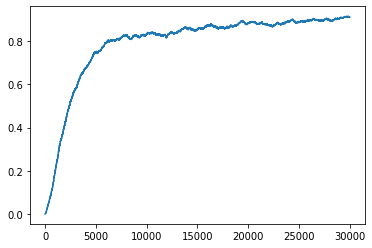

In [17]:
ema_var, steps = ema(Reward_history_0)
plt.plot(steps, ema_var)

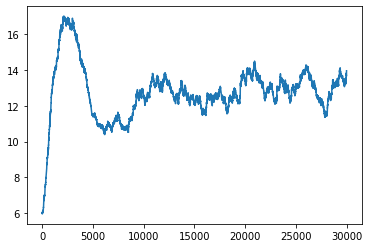

In [18]:
ema_var, steps = ema(Moves_history_0)
plt.plot(steps, ema_var)

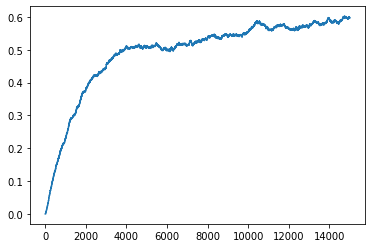

In [19]:
ema_var, steps = ema(Reward_history_changed_gamma_2)
plt.plot(steps, ema_var)

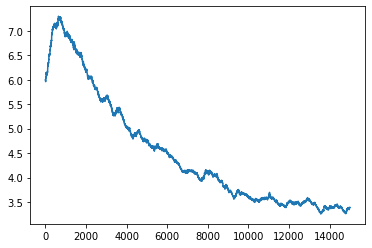

In [20]:
ema_var, steps = ema(Moves_history_changed_gamma_2)
plt.plot(steps, ema_var)

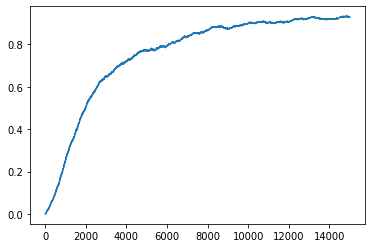

In [21]:
ema_var, steps = ema(Reward_history_changed_beta_2)
plt.plot(steps, ema_var)

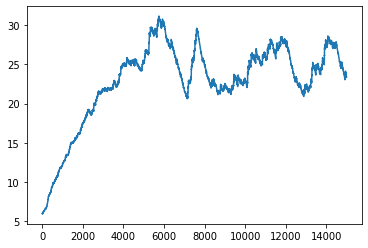

In [22]:
ema_var, steps = ema(Moves_history_changed_beta_2)
plt.plot(steps, ema_var)

### Comparison Graphs

In [23]:
def plot_function(history1, history2, label2):
    ema_reward_1, steps = ema(history1)
    ema_reward_2, steps = ema(history2)

    plt.plot(steps, ema_reward_1, label = "Reward Orignal")
    plt.plot(steps, ema_reward_2, label = label2)
    plt.legend()
    plt.show()

With a new Gamma of 0.03

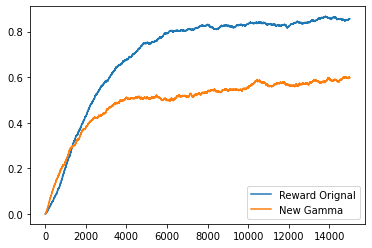

In [24]:
# Reward
plot_function(Reward_history_0_small, Reward_history_changed_gamma_2, "New Gamma")

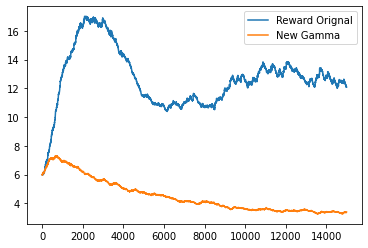

In [25]:
# Number of Moves
plot_function(Moves_history_0_small, Moves_history_changed_gamma_2, "New Gamma")

With a new Beta of 0.0005

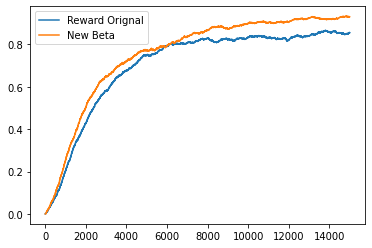

In [26]:
# Reward
plot_function(Reward_history_0_small, Reward_history_changed_beta_2, "New Beta")

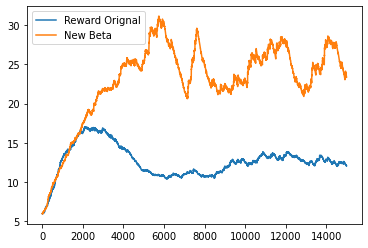

In [27]:
# Number of Moves
plot_function(Moves_history_0_small, Moves_history_changed_beta_2, "New Beta")

# Deep Double Q-Learning
First we need to set the parameters for this learning algorithm


In [28]:
# set the hyper parameters for training

# number of nodes in the hidden layer
size_hidden_layer = 200

# exploit our current knowledge with 1-epsilon and take a random action with probability epsilon (explore)
epsilon_0 = 0.2  

# how quick epsilon is decaying
beta = 0.00005

# discount factor (how much we discount future rewards)
gamma = 0.85     

# learning rate
eta = 0.0035

# number of games to be played
N_episodes = 30000

# how often A is updated
update_A = 0.5

In [29]:
# training loop: Double Q-Learning

# initialize (nan) counters to see development of rewards and the number of moves per game
Reward_history_double_Q = np.full([N_episodes, 1], np.nan)
Moves_history_double_Q = np.full([N_episodes, 1], np.nan)

# initialize the neural network
neural_network_A = Neural_Network(size_hidden_layer, eta, gamma)
neural_network_B = Neural_Network(size_hidden_layer, eta, gamma)

# initialize policy
policy = Policies("epsilon_greedy")

for n in range(N_episodes):
    
    # decay the epsiolon to have the model explore more in the beginnign
    epsilon_in_game = epsilon_0 / (1 + beta * n)
    
    # set Done (back) to the initial value (beginning of the episode)
    Done=0 
    
    # counter for number of actions
    i = 1 
    
    # reset to a new state/game
    S,X,allowed_a=env.Initialise_game()
    
    # format the state of the game for neural network
    X = neural_network_A.add_column_for_bias(X)
    
    # while the game is not over
    while Done == 0:
        
        # get the Q values
        Q_values_A = neural_network_A.forward(X, False)
        Q_values_B = neural_network_B.forward(X, False)
        
        # get an action according to the policy
        one_hot_action, action = policy.get_choosen_action(Q_values_A + Q_values_B, allowed_a, epsilon_in_game)
        
        # do the next step
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
        
        # format the state of the game for neural network
        X_next = neural_network_A.add_column_for_bias(X_next)
        
        
        # if game is finished update Q_values without Q_next
        if Done == 1:
            
            # Update(A) or Update (B)
            if np.random.rand() < update_A:
                # we update Q_values of A
                
        
                # update the Q values of A with the Q_values of B
                #Qa(x) = Q_values_A
                # reward = R
                # gamma
                # QB(X_prime, np.max())
                neural_network_A.backward(R, Q_values_A, None, X, one_hot_action)

            else:
                # we update Q_values of B
                
                # update the Q values of B with the Q_values of A
                neural_network_B.backward(R, Q_values_B, None, X, one_hot_action)
            
            # set the reward for an episode
            np.put(Reward_history_double_Q, n, R)
            np.put(Moves_history_double_Q, n, i)
            
            # display progress
            display_progress(n, i, R, 1000)
            
            # stop the while loop and start a new game
            break
        
        # the game is NOT finished yet
        else:
             # Update(A) or Update (B)
            if np.random.rand() < update_A:
                # we update Q_values of A
                
                # calculate the next Q_values for B
                #  QA(X_next, a = parameter)
                Q_next_A = neural_network_A.forward(X_next, True)
                
                # arg max on action -> set epsilon to 0 -> therefore it is greedy and we get max value
                # then we can extract 
                one_hot_action_star, action_star = policy.get_choosen_action(Q_next_A, allowed_a, 0)
                
                Q_next_B_action_star = neural_network_B.forward(X_next, True)[action_star]
                
                # update the Q values of A with the Q_values of B
                neural_network_A.backward(R, Q_values_A, Q_next_B_action_star, X, one_hot_action)

            else:
                # we update Q_values of B
                
                # calculate the next Q_values for A
                #  QA(X_next, a = parameter)
                Q_next_B = neural_network_B.forward(X_next, True)
                
                # arg max on a (a is a parameter)
                one_hot_action_star, action_star = policy.get_choosen_action(Q_next_B, allowed_a, 0)
                
                Q_next_A_action_star = neural_network_A.forward(X_next, True)[action_star]
                
                # update the Q values of A with the Q_values of B
                neural_network_B.backward(R, Q_values_B, Q_next_A_action_star, X, one_hot_action)

            
            # next state becomes current state
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
            # update number of actions
            i += 1
    

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.22; Nr of needed moves: 8
==== In episode 2000; Reward: 0.4158; Nr of needed moves: 1
==== In episode 3000; Reward: 0.5669; Nr of needed moves: 20
==== In episode 4000; Reward: 0.6372; Nr of needed moves: 3
==== In episode 5000; Reward: 0.6545; Nr of needed moves: 4
==== In episode 6000; Reward: 0.6814; Nr of needed moves: 24
==== In episode 7000; Reward: 0.6883; Nr of needed moves: 5
==== In episode 8000; Reward: 0.7043; Nr of needed moves: 27
==== In episode 9000; Reward: 0.712; Nr of needed moves: 4
==== In episode 10000; Reward: 0.7134; Nr of needed moves: 38
==== In episode 11000; Reward: 0.7355; Nr of needed moves: 4
==== In episode 12000; Reward: 0.7287; Nr of needed moves: 2
==== In episode 13000; Reward: 0.7463; Nr of needed moves: 2
==== In episode 14000; Reward: 0.7406; Nr of needed moves: 4
==== In episode 15000; Reward: 0.7453; Nr of needed moves: 1
==== In episode 16000; Reward: 0.7479; 

### Analysis of the results

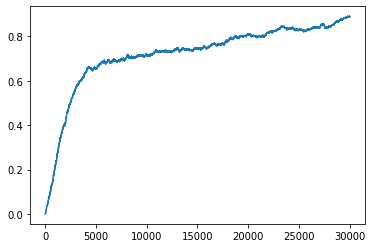

In [30]:
ema_var, steps = ema(Reward_history_double_Q)
plt.plot(steps, ema_var)

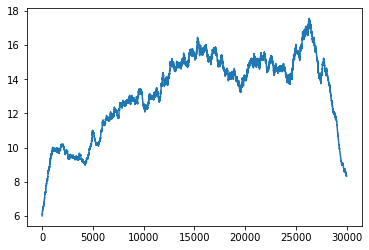

In [31]:
ema_var, steps = ema(Moves_history_double_Q)
plt.plot(steps, ema_var)

# Sarsa

In [32]:
# set the hyper parameters for training

# number of nodes in the hidden layer
size_hidden_layer = 200

# exploit our current knowledge with 1-epsilon and take a random action with probability epsilon (explore)
epsilon_0 = 0.2  

# how quick epsilon is decaying
beta = 0.00005

# discount factor (how much we discount future rewards)
gamma = 0.85     

# learning rate
eta = 0.0035

# number of games to be played
N_episodes = 30000

In [33]:
# training loop: Q-Learning
np.random.seed(21)

# initialize (nan) counters to see development of rewards and the number of moves per game
Reward_history = np.full([N_episodes, 1], np.nan)
Moves_history = np.full([N_episodes, 1], np.nan)

# initialize the neural network
neural_network = Neural_Network(size_hidden_layer, eta, gamma)

# initialize policy
policy = Policies("epsilon_greedy")

for n in range(N_episodes):
    
    # decay the epsiolon to have the model explore more in the beginnign
    epsilon_in_game = epsilon_0 / (1 + beta * n)
    
    # set Done (back) to the initial value (beginning of the episode)
    Done=0 
    
    # counter for number of actions
    i = 1 
    
    # reset to a new state/game
    S,X,allowed_a=env.Initialise_game()
    
    # format the state of the game for neural network
    X = neural_network.add_column_for_bias(X)
    
    # get the Q values
    Q_values = neural_network.forward(X, False)
        
    # get an action according to the policy
    one_hot_action, action = policy.get_choosen_action(Q_values, allowed_a, epsilon_in_game)
    
    # while the game is not over
    while Done == 0:
        
        # do the next step
        S_next, X_next, allowed_a_next, R, Done = env.OneStep(action)
        
        # format the state of the game for neural network
        X_next = neural_network.add_column_for_bias(X_next)
        
        # if game is finished update Q_values without Q_next
        if Done == 1:
            
            # calculate gradients and update weights
            neural_network.backward(R, Q_values, None, X, one_hot_action)
            
            # set the reward for an episode
            np.put(Reward_history, n, R)
            np.put(Moves_history, n, i)
            
            # display progress (every 1000th step)
            display_progress(n, i, R, 1000)
            
            # stop the while loop and start a new game
            break
        
        # the game is NOT finished yet
        else:
            # calculate the next Q_values according to the Q-Learning algorithm
            a1_next, h1_next, a2_next, Q_values_next = neural_network.forward(X_next, "Sarsa")
            
            # get an action according to the policy
            one_hot_action_next, action_next = policy.get_choosen_action(Q_values_next, allowed_a_next, epsilon_in_game)
            
            # TODO why this
            # get Qvalue of next action
            Q_next = Q_values_next[action_next]
            Q_next = np.tile(Q_next, (32, 1))
            
            # backpropagate with all the data and get update the weights
            neural_network.backward(R, Q_values, Q_next, X, one_hot_action)
            
            
            # next state becomes current state
            neural_network.set_new_node_values(a1_next, h1_next, a2_next)
            Q_values = Q_values_next
            action = np.copy(action_next)
            one_hot_action = one_hot_action_next
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
            
            # update number of actions
            i += 1

==== In episode 0; Reward: 0.0; Nr of needed moves: 6
==== In episode 1000; Reward: 0.2812; Nr of needed moves: 14
==== In episode 2000; Reward: 0.4871; Nr of needed moves: 1
==== In episode 3000; Reward: 0.6053; Nr of needed moves: 12
==== In episode 4000; Reward: 0.6513; Nr of needed moves: 1
==== In episode 5000; Reward: 0.6976; Nr of needed moves: 5
==== In episode 6000; Reward: 0.7126; Nr of needed moves: 3
==== In episode 7000; Reward: 0.7482; Nr of needed moves: 1
==== In episode 8000; Reward: 0.7727; Nr of needed moves: 6
==== In episode 9000; Reward: 0.7998; Nr of needed moves: 7
==== In episode 10000; Reward: 0.827; Nr of needed moves: 4
==== In episode 11000; Reward: 0.8674; Nr of needed moves: 10
==== In episode 12000; Reward: 0.8715; Nr of needed moves: 1
==== In episode 13000; Reward: 0.8912; Nr of needed moves: 3
==== In episode 14000; Reward: 0.8933; Nr of needed moves: 1
==== In episode 15000; Reward: 0.9019; Nr of needed moves: 9
==== In episode 16000; Reward: 0.9202;

### Analysis of the results

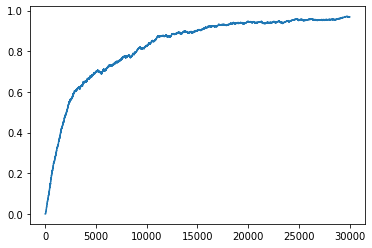

In [34]:
ema_var, steps = ema(Reward_history)
plt.plot(steps, ema_var)

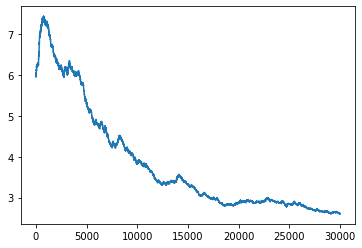

In [35]:
ema_var, steps = ema(Moves_history)
plt.plot(steps, ema_var)